In [ ]:
!pip install emoji textblob transformers langdetect googletrans==4.0.0rc1 datasets --quiet

In [ ]:
import pandas as pd
import numpy as np
import nltk
import re
from textblob import TextBlob
import emoji
import matplotlib.pyplot as plt
import seaborn as sns
import warnings; warnings.simplefilter('ignore')
from transformers import pipeline
from langdetect import detect
from googletrans import Translator
from datasets import load_dataset
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score,confusion_matrix

In [ ]:
ds = load_dataset("tyqiangz/multilingual-sentiments", "all")

Generating train split:   0%|          | 0/270399 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/10857 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/14465 [00:00<?, ? examples/s]

In [ ]:
df_emoji = pd.read_csv("Emoji_Sentiment_Data.csv",usecols = ['Emoji', 'Negative', 'Neutral', 'Positive'])
df_emoji.head(3)

,Emoji,Negative,Neutral,Positive
0,😂,3614,4163,6845
1,❤,355,1334,6361
2,♥,252,1942,4950


In [ ]:
polarity_list = []
for index, row in df_emoji.iterrows():
    polarity=0
    arg_1=row['Positive'] > row['Negative']
    arg_2=row['Positive'] == row['Negative'] and row['Neutral'] % 2 != 0
    if arg_1 or arg_2:
        polarity = 1
    polarity_list.append(polarity)
new_df_emoji=pd.DataFrame(polarity_list, columns=['sentiment'])
new_df_emoji['emoji'] = df_emoji['Emoji'].values
new_df_emoji.head(3)

,sentiment,emoji
0,1,😂
1,1,❤
2,1,♥


In [ ]:
text = "i ❤ sentiments #goodlife @today"
def extract_text_and_emoji(text = text):
    global allchars, emoji_list
    removekeys=('@', 'http://','https://', '&', '#')
    clean_text=' '.join(txt for txt in text.split() if not txt.startswith(removekeys))
    print(clean_text)
    allchars=[str for str in text]
    emoji_list=[c for c in allchars if c in emoji.EMOJI_DATA]
    clean_text=' '.join([str for str in clean_text.split() if not any(i in str for i in emoji_list)])
    clean_emoji= ''.join([str for str in text.split() if any(i in str for i in emoji_list)])
    return (clean_text, clean_emoji)
allchars, emoji_list = 0, 0
(ct, ce)=extract_text_and_emoji()
print('\nAll Char:', allchars)
print('\nAll Emoji:',emoji_list)
print('\n', ct)
print('\n',ce)

i ❤ sentiments

All Char: ['i', ' ', '❤', ' ', 's', 'e', 'n', 't', 'i', 'm', 'e', 'n', 't', 's', ' ', '#', 'g', 'o', 'o', 'd', 'l', 'i', 'f', 'e', ' ', '@', 't', 'o', 'd', 'a', 'y']

All Emoji: ['❤']

 i sentiments

 ❤


In [ ]:
def detect_and_translate2(text):
    pipe = pipeline("translation", model="Helsinki-NLP/opus-mt-mul-en")
    translation = pipe(text)
    return translation[0]['translation_text']
sentiment_pipeline = pipeline('sentiment-analysis')

In [ ]:
x="Der Dubbletimepart von Julien war ja mal sowas von genial! "
ss=detect_and_translate2(x)
print(ss)

In [ ]:
def get_sentiment(s_input='i hate sentiment analysis'):
    results = sentiment_pipeline(s_input)
    pred_senti = results[0]['label']
    if pred_senti == 'POSITIVE':
        pc = 1
    else:
        pc = 0
    return pc
print(get_sentiment())

0


In [ ]:
def get_emoji_sentiment(emoji_ls = '❤❤', emoji_df = new_df_emoji):
    emoji_val_ls = []
    for e in emoji_ls:
        get_emo_senti = [row['sentiment'] for index, row in emoji_df.iterrows() if row['emoji'] == e]
        if get_emo_senti:  
            emoji_val_ls.append(get_emo_senti[0])
        else:
            emoji_val_ls.append(0)  
    return emoji_val_ls
ges = get_emoji_sentiment()
print('Sentiment value of each emoji:',ges)

Sentiment value of each emoji: [1, 1]


In [ ]:
def analyze_emotion(text):
    blob = TextBlob(text)
    sentiment = blob.sentiment
    if sentiment.polarity > 0:
        if sentiment.subjectivity > 0.5:
            return "joy"  
        else:
            return "surprise"  
    elif sentiment.polarity < 0:
        if sentiment.subjectivity > 0.5:
            return "anger" 
        else:
            return "sadness"  
    else:
        return "neutral"  
tweet = "Had a terrible experience at the restaurant tonight. Never going back."
emotion = analyze_emotion(tweet)
print(f"Emotion: {emotion}")

Emotion: sadness


In [ ]:
def get_text_emoji_sentiment(input_test = 'i hate 😒 sentiment analysis'):
    (ext_text, ext_emoji) = extract_text_and_emoji(input_test)
    print(f'Extracted: "{ext_text}" , {ext_emoji}')
    ttext=""
    lang = detect(ext_text)
    if lang!="en":
      ext_text= detect_and_translate2(ext_text)
      print(f'Translated: "{ext_text}"')
    senti_text = get_sentiment(ext_text)
    print(f'Text value: {senti_text}')
    senti_emoji_value = sum(get_emoji_sentiment(ext_emoji, new_df_emoji))
    print_emo_val_avg = 0 if len(ext_emoji) == 0 else senti_emoji_value/len(ext_emoji)
    print(f'Emoji average value: {print_emo_val_avg}')
    senti_avg = (senti_emoji_value + senti_text) / (len(ext_emoji) + 1)
    print(f'Average value: {senti_avg}')
    senti_truth = "Positive" if senti_avg >= 0.5 else "Negative"
    emtext = analyze_emotion(ext_text)
    print(f'Text Emotion: {emtext}')
    return senti_truth
print(get_text_emoji_sentiment())

In [ ]:
datasetnew=ds['test'].to_pandas()
datasetnew.head(4)
datasetnew.to_csv('dataset.csv', index=False)

In [ ]:
japanese_indices=datasetnew[datasetnew['language'].apply(detect) == 'japanese'].index
chinese_indices=datasetnew[datasetnew['language'].apply(detect) == 'chinese'].index
removejap=min(2000, len(japanese_indices))
removechin=min(2000 - removejap, len(chinese_indices))
indices_to_remove=japanese_indices[:removejap].tolist() + chinese_indices[:removechin].tolist()
datasetnew=datasetnew.drop(indices_to_remove)

In [ ]:
test_df = pd.read_csv("test.csv",usecols = ['text', 'label'])
test_df=test_df[test_df['label'] != 1]
test_df['label'] = test_df['label'].apply(lambda x: 1 if x == 'positive' else 0)
x=test_df.head(7)

In [ ]:
print(datasetnew['language'].value_counts())

In [ ]:
def preprocess_text(text):
    text=text.lower()
    text=' '.join(word for word in text.split() if not word.startswith(('@', 'http', '#' ,'$' ,'*' ,'|' ,'+')))
    text=' '.join([str for str in text.split() if not any(i in str for i in emoji_list)])
    text=re.sub(r'\d+', '', text)
    text=re.sub(r'[^\w\s]', '', text)
    return text if text else " "
test_df['text'] = test_df['text'].apply(preprocess_text)

def get_sentiment(text):
    result=sentiment_pipeline(text)[0]['label']
    return 1 if result == 'POSITIVE' else 0
test_df['predicted_sentiment']= test_df['text'].apply(get_sentiment)

In [ ]:
y_true = test_df['label']
y_pred = test_df['predicted_sentiment']
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

print("Accuracy ", accuracy)
print("Precision ", precision)
print("Recall ", recall)
print("F1 Score ", f1)

Accuracy  0.7241379310344828
Precision  0.5679347826086957
Recall  0.7206896551724138
F1 Score  0.6352583586626139


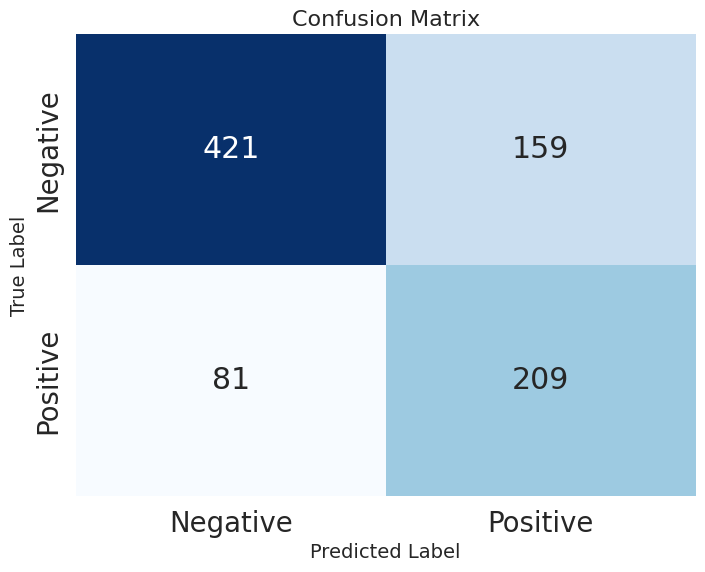

In [ ]:
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.8)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted Label', fontsize=14)
plt.ylabel('True Label', fontsize=14)
plt.title('Confusion Matrix', fontsize=16)
plt.show()

In [ ]:
tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
print("True Negatives:", tn)
print("False Positives:", fp)
print("False Negatives:", fn)
print("True Positives:", tp)

True Negatives: 421
False Positives: 159
False Negatives: 81
True Positives: 209


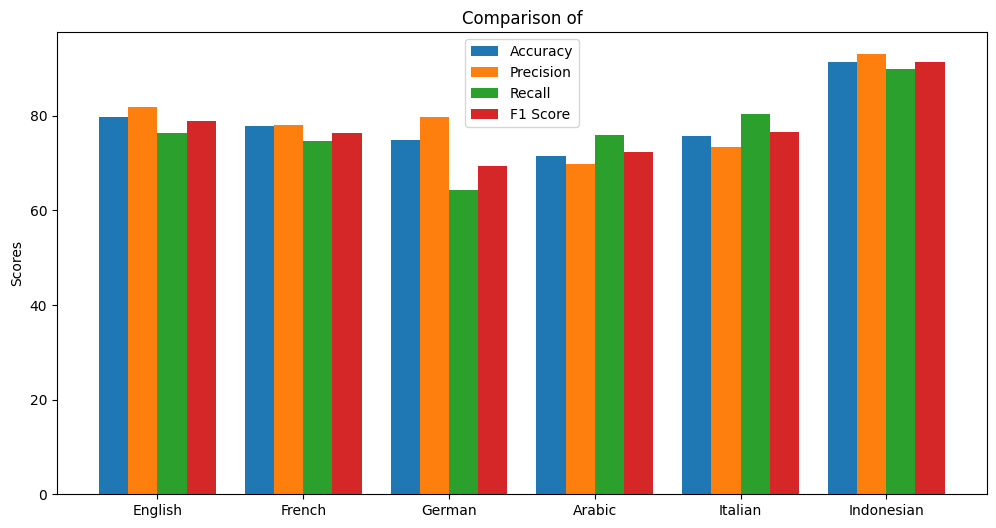

In [ ]:
languages = ["English", "French", "German", "Arabic", "Italian", "Indonesian"]
accuracy = [79.78, 77.90, 74.89, 71.57, 75.79, 91.50]
precision = [81.88, 78.13, 79.71, 69.87, 73.42, 93.03]
recall = [76.40, 74.65, 64.37, 75.89, 80.43, 89.92]
f1 = [78.95, 76.35, 69.43, 72.27, 76.64, 91.44]
x = np.arange(len(languages))  
width = 0.2  

fig, ax = plt.subplots(figsize=(12, 6))
rects1 = ax.bar(x - 1.5*width, accuracy, width, label='Accuracy')
rects2 = ax.bar(x - 0.5*width, precision, width, label='Precision')
rects3 = ax.bar(x + 0.5*width, recall, width, label='Recall')
rects4 = ax.bar(x + 1.5*width, f1, width, label='F1 Score')

ax.set_ylabel('Scores')
ax.set_title('Comparison of')
ax.set_xticks(x)
ax.set_xticklabels(languages)
ax.legend()